<a href="https://colab.research.google.com/github/brad0taylor/Graph/blob/master/alu_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ALU Demo
* NN is used to emulate classic ALU with Add/Sub, Bitwise, Trig functions
* Setup for values between -100 and +100


## Import Modules

In [2]:
from __future__ import print_function
import keras.backend as K 
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Lambda
from keras.layers import Conv2D, MaxPooling2D
from keras.utils  import to_categorical
from keras import regularizers
from keras.layers import RNN, dot
from keras import optimizers



import os

import numpy as np
import math

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Found GPU at: /device:GPU:0


In [0]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import  sys
def printf(format, *args):
#    print(format % args )
    sys.stdout.write(format % args)
    
#printf('x0=%f3', x[0,0] )

In [4]:
print('GPU')
!nvidia-smi

#no.of cores each processor is having 
print('CPU cores')
!lscpu | grep 'Core(s) per socket:'
 
# no.of threads each core is having 
print('CPU Threads')
!lscpu | grep 'Thread(s) per core'

print('L3')
!lscpu | grep "L3 cache"

#if it had turbo boost it would've shown Min and Max MHz also but it is only showing current frequency this means it always operates at 2.3GHz
print('Freq')
!lscpu | grep "MHz"

#memory that we can use
print('mem avail')
!cat /proc/meminfo | grep 'MemAvailable'

print('Disk')
!df -h / | awk '{print $4}'

#hard disk that we can use
print('Disk avail')
!df -h / | awk '{print $4}'




GPU
Sat Jun 22 20:02:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |    129MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  G

##Utility Functions

In [5]:
def bit_count(n):
      assert n >= 0, 'Argument of bit_count() must be non-negative'
      count = 0
      while n:
          n &= n - 1
          count += 1
      return count
  

for i in range(10) :
  ii=int(i)
  bits= bit_count(i)
  print(bin(ii),bits)
  

0b0 0
0b1 1
0b10 1
0b11 2
0b100 1
0b101 2
0b110 2
0b111 3
0b1000 1
0b1001 2


##Create 26 opcodes by initialization patterns

(52000, 1, 28) (52000, 1)


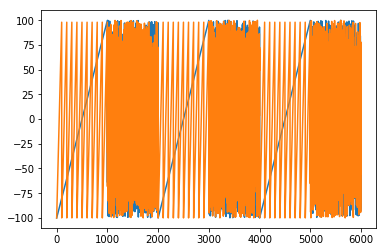

opcodes= 26 ['cst0' 'sign' 'sela' 'selb' 'add' 'sub' 'mult' 'div' 'mod' 'max' 'min'
 'abs' 'log' 'exp' 'sin' 'cos' 'tanh' 'xor' 'shft' 'and' 'or' 'popc'
 'inta' 'intb' 'bit0' 'bitx']
[ 999,0] op=cst0 opA=99.80 opB=98.00 out=   +0.00  ---- A= 63cc B= 6200 O=    0 --- a=       0b1100011 b=       0b1100010 o=                             0b0 
[2999,0] op=sign opA=99.80 opB=98.00 out= +100.00  ---- A= 63cc B= 6200 O= 6400 --- a=       0b1100011 b=       0b1100010 o=                       0b1100100 
[4999,0] op=sela opA=99.80 opB=98.00 out=  +99.80  ---- A= 63cc B= 6200 O= 63cc --- a=       0b1100011 b=       0b1100010 o=                       0b1100011 
[6999,0] op=selb opA=99.80 opB=98.00 out=  +98.00  ---- A= 63cc B= 6200 O= 6200 --- a=       0b1100011 b=       0b1100010 o=                       0b1100010 
[8999,0] op= add opA=99.80 opB=98.00 out= +197.80  ---- A= 63cc B= 6200 O= c5cc --- a=       0b1100011 b=       0b1100010 o=                      0b11000101 
[10999,0] op= sub opA=99.80

In [6]:
#make the ops
#x=np.vstack((np.random.rand(1000,10),-np.random.rand(1000,10)))
#y=np.vstack((np.ones((1000,1)),np.zeros((1000,1))))

scale = 200
offset = 100

nvars=2
nops=26
opsize=1000*2
nsamp=nops*opsize
ncat = 100
nbin = 8

x=np.random.random((nsamp,1,28))*scale-offset
y=np.zeros((nsamp,1))



op  = np.zeros(nsamp,int)
op  = op.astype(str)
opcodes  = np.zeros(nops)
opcodes  = op.astype(str)
opcode=0

if 1 :
  # initialize initial data
  for i in range(int(nsamp/opsize)) :
    for j in range (10) :
      for k in range(100) :
        x[i*opsize+j*100+k,0,0]=(j/10+k/1000 )*scale-offset
        x[i*opsize+j*100+k,0,1]=(k*1/100     )*scale-offset
    
print(x.shape, y.shape)
plt.plot(x [0:6000,0,0:2],'-')
#plt.plot(y [0:nsamp], '-')
#plt.plot(yo[0:nsamp], '-')
plt.show()

  


def bit_count(n):
#   assert n >= 0, 'Argument of bit_count() must be non-negative'
    count = 0
    while n:
        n &= n - 1
        count += 1
    return count
  
i=0;

if(1) :
  # cst0
  n=opsize 
  x[ i:i+n,:,nvars:nops+nvars] =  to_categorical(opcode, nops)
  y[ i:i+n,:     ] = 0
  op[i:i+n]='cst0'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # sign 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = np.sign(x[i:i+n,:,0]  )*100
  op[i:i+n]='sign'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  


if(1) :
  # sela
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = x[ i:i+n,:,0]
  op[i:i+n]='sela'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1
  
  #selb 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = x[ i:i+n,:,1]
  op[i:i+n]='selb'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if(1) :

  # add 
  n=opsize 
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = x[i:i+n,:,0] + x[i:i+n,:,1] 
  op[i:i+n]='add'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1
  
if(1)  :
  # sub 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = x[i:i+n,:,0] - x[i:i+n,:,1] 
  op[i:i+n]='sub'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if(1) :
  # mult 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = x[i:i+n,:,0] * x[i:i+n,:,1] / 100
  op[i:i+n]='mult'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1

if(1) :  
  # div 
  n=opsize 
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    if x[i+j,:,1]!=0 :
      y[ i+j,0     ] = x[i+j,0,0] / x[i+j,0,1]
    else :
      y[ i+j,0     ] = 0
  op[i:i+n]='div'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # mod 
  n=opsize 
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    if x[i+j,:,1]!=0 :
      y[ i+j,0     ] = x[i+j,0,0] % x[i+j,0,1]
    else :
      y[ i+j,0     ] = 0
  op[i:i+n]='mod'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if (1) :
  # max 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = np.maximum( x[i:i+n,:,0] ,  x[i:i+n,:,1] )
  op[i:i+n]='max'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1
  
  # min 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = np.minimum(x[i:i+n,:,0] ,  x[i:i+n,:,1] )
  op[i:i+n]='min'
  opcodes[opcode]=op[i]
  i=i+n; opcode=opcode+1
  
  
  # abs 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = np.abs(x[i:i+n,:,0]  )
  op[i:i+n]='abs'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if(1):
  # log 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    if x[i+j,0,0]>0 :
      y[ i+j,0     ] = min(100,np.log(x[i+j,0,0] )*40)
    else :
      y[ i+j,0     ] = 0
  

  op[i:i+n]='log'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # e^x 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    y[ i+j,0     ]= min(200,np.exp(x[i+j,0,0]/100 )*50 )
  op[i:i+n]='exp'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # sin 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = np.sin(x[i:i+n,:,0]/scale*3.14*4 )*100
  op[i:i+n]='sin'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # cos 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = np.cos(x[i:i+n,:,0]/scale*3.14*4 )*100
  op[i:i+n]='cos'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  # tanh 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  y[ i:i+n,:     ] = np.tanh(x[i:i+n,:,0]/scale*3.14*4)*100
  op[i:i+n]='tanh'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

if(1) :
   # xor
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0]) ^ np.int(x[i+j,:,1])  )
  op[i:i+n]='xor'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # shift 
  n=opsize 
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0]) << max(0,min(4,np.int(x[i+j,:,1]/25) )) )/8
  op[i:i+n]='shft'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # and
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0]) & np.int(x[i+j,:,1])  )
  op[i:i+n]='and'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  
  # or
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] =to_categorical(opcode, nops)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0]) | np.int(x[i+j,:,1])  )
  op[i:i+n]='or'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1
  
  
   
  
  
  # bitcount
  
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    y[ i+j,0     ] = bit_count(max(0,np.int(x[i+j,:,0]))) * 8
  op[i:i+n]='popc'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # inta 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,0])) 
  op[i:i+n]='inta'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  # intb 
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    y[ i+j,0     ] = (np.int(x[i+j,:,1])) 
  op[i:i+n]='intb'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

  
  # bit 0
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    
    y[ i+j,0     ] = ((np.int(x[i+j,:,0])) & 1)*100
  op[i:i+n]='bit0'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1

   # bit extract
  n=opsize
  x[ i:i+n,:,nvars:nops+nvars] = to_categorical(opcode, nops)
  for j in range(n):
    
    y[ i+j,0     ] = ((np.int(x[i+j,:,0]))>>max(0,min(16,np.int(x[i+j,:,1]/25))) & 1)*100
  op[i:i+n]='bitx'
  opcodes[opcode]=op[i]
  i=i+n;  opcode=opcode+1


print("opcodes=", opcode, opcodes[0:opcode])






#xcat0= np.zeros((nsamp,100))
#xcat1= np.zeros((nsamp,100))

model='alu1'

for ii  in range (0,nsamp,int(nsamp/nops)) :
  for t in range (1) :   
    i=ii+999 
    printf('[%4d,%d] op=%4s opA=%2.2f opB=%2.2f out=%+8.2f  ---- A=%5x B=%5x O=%5x --- a=%16s b=%16s o=%32s \n', i, t, op[i], x[i,t,0], x[i,t,1], y[i], int(x[i,t,0]*256), int(x[i,t,1]*256), int(y[i]*256) , bin(int(x[i,t,0])), bin(int(x[i,t,1])), bin(int(y[i])))
 


In [7]:
#create all the input versions

xcat0= to_categorical(x[:,0,0],100)
xcat1= to_categorical(x[:,0,1],100)

xbit0= np.zeros((nsamp,16))
xbit1= np.zeros((nsamp,16))

xfrac0 = np.zeros((nsamp))
xfrac1 = np.zeros((nsamp))

print(xbit0.shape, xfrac0.shape)

#create bit array

for j in range(16) :
  for i in range(nsamp):
    xbit0[i,j] = (np.int(x[i,:,0]*256)>>j)&1
    xbit1[i,j] = (np.int(x[i,:,1]*256)>>j)&1
                  
for i in range(nsamp):
                  
    xfrac0[i] = x[i,:,0]- np.int(x[i,:,0])
    xfrac1[i] = x[i,:,1]- np.int(x[i,:,1])

for i in range(10):

  printf("i=%d, x0=%6.1f, x0f=%6.3f xbits=%d,%d,%d,%d  %d,%d,%d,%d\n", i, x[i,0,0], xfrac0[i], xbit0[i,7], xbit0[i,6],xbit0[i,5],xbit0[i,4],xbit0[i,3], xbit0[i,2],xbit0[i,1],xbit0[i,0] )
  printf("i=%d, x1=%6.1f, x1f=%6.3f xbits=%d,%d,%d,%d  %d,%d,%d,%d\n", i, x[i,0,1], xfrac1[i], xbit1[i,7], xbit1[i,6],xbit1[i,5],xbit1[i,4],xbit1[i,3], xbit1[i,2],xbit1[i,1],xbit1[i,0] )





(52000, 16) (52000,)
i=0, x0=-100.0, x0f= 0.000 xbits=0,0,0,0  0,0,0,0
i=0, x1=-100.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=1, x0= -99.8, x0f=-0.800 xbits=0,0,1,1  0,1,0,0
i=1, x1= -98.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=2, x0= -99.6, x0f=-0.600 xbits=0,1,1,0  0,1,1,1
i=2, x1= -96.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=3, x0= -99.4, x0f=-0.400 xbits=1,0,0,1  1,0,1,0
i=3, x1= -94.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=4, x0= -99.2, x0f=-0.200 xbits=1,1,0,0  1,1,0,1
i=4, x1= -92.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=5, x0= -99.0, x0f= 0.000 xbits=0,0,0,0  0,0,0,0
i=5, x1= -90.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=6, x0= -98.8, x0f=-0.800 xbits=0,0,1,1  0,1,0,0
i=6, x1= -88.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=7, x0= -98.6, x0f=-0.600 xbits=0,1,1,0  0,1,1,1
i=7, x1= -86.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=8, x0= -98.4, x0f=-0.400 xbits=1,0,0,1  1,0,1,0
i=8, x1= -84.0, x1f= 0.000 xbits=0,0,0,0  0,0,0,0
i=9, x0= -98.2, x0f=-0.200 xbits=1,1,0,0  1,1,0,1
i=9, x1= -82.0, x1f= 0.000 xb

In [8]:
#create array of bits for y
ybit  =np.zeros((nsamp,16))
#print(y.shape, yy.shape, yint.shape)
yint=y*256 
ioff=3000

print(y[ioff:ioff+10,0], yint[ioff:ioff+10,0])

for j in range(16) :
  for i in range(nsamp):
    ybit[i,j] = (np.int(y[i,0]*256)>>j)&1

    
for i in range(ioff,ioff+10):

  printf("i=%d, op=%s y=%6.1f, ybits=%d,%d,%d,%d  %d,%d,%d,%d  %d,%d,%d,%d  %d,%d,%d,%d\n", i, op[i], y[i,0], \
         ybit[i,0], ybit[i,1],ybit[i, 2],ybit[i, 3],ybit[i, 4], ybit[i, 5],ybit[i, 6],ybit[i, 7],      \
         ybit[i,8], ybit[i,9],ybit[i,10],ybit[i,11],ybit[i,12], ybit[i,13],ybit[i,14],ybit[i,15] )



[-100. -100.  100. -100. -100. -100.  100. -100.  100. -100.] [-25600. -25600.  25600. -25600. -25600. -25600.  25600. -25600.  25600.
 -25600.]
i=3000, op=sign y=-100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,1  1,0,0,1
i=3001, op=sign y=-100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,1  1,0,0,1
i=3002, op=sign y= 100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,0  0,1,1,0
i=3003, op=sign y=-100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,1  1,0,0,1
i=3004, op=sign y=-100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,1  1,0,0,1
i=3005, op=sign y=-100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,1  1,0,0,1
i=3006, op=sign y= 100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,0  0,1,1,0
i=3007, op=sign y=-100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,1  1,0,0,1
i=3008, op=sign y= 100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,0  0,1,1,0
i=3009, op=sign y=-100.0, ybits=0,0,0,0  0,0,0,0  0,0,1,1  1,0,0,1


##Make some experimental models

In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras import layers
from keras.datasets import mnist
from keras import backend as K


class sinlayer(layers.Layer):


    def compute_output_shape(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 2  # only valid for 2D tensors
        shape[-1] *= 3
        return tuple(shape)

    def call(self, inputs):
        #inputs -= K.mean(inputs, axis=1, keepdims=True)
        #inputs = K.l2_normalize(inputs, axis=1)
        pos = inputs
        sin = K.sin(inputs)
        cos = K.cos(inputs)
        return K.concatenate([pos, sin, cos], axis=1)

# global parameters
batch_size = 128
num_classes = 10
epochs = 40

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# build the model
model = Sequential()
model.add(layers.Dense(256, input_shape=(784,)))
model.add(sinlayer())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(256))
model.add(sinlayer())
model.add(layers.Dropout(0.1))
model.add(layers.Dense(num_classes))
model.add(layers.Activation('softmax'))

# compile the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# train the model
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

# next, compare with an equivalent network
# with2x bigger Dense layers and ReLU

11493376/11490434 [==============================] - 1s 0us/step


W0618 17:41:35.820693 140535797401472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0618 17:41:35.827673 140535797401472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0618 17:41:35.838032 140535797401472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0618 17:41:35.860120 140535797401472 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0618 17:41:35.870993 

60000 train samples
10000 test samples


W0618 17:41:36.117501 140535797401472 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 5s 91us/step - loss: 0.3927 - acc: 0.8858 - val_loss: 0.1556 - val_acc: 0.9513
Epoch 2/40
11136/60000 [====>.........................] - ETA: 2s - loss: 0.1568 - acc: 0.9506

KeyboardInterrupt: ignored

In [0]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras import layers
from keras.datasets import mnist
from keras import backend as K
from keras.layers import Concatenate


class clip10layer(layers.Layer):

  def compute_output_shape(self, input_shape):
    shape = list(input_shape)
    assert len(shape) == 2  # only valid for 2D tensors
    shape[-1] *= 11
    return tuple(shape)
  
  def call(self, inputs):
  #        inputs -= K.mean(inputs, axis=1, keepdims=True)
  #        inputs = K.l2_normalize(inputs, axis=1)
    print('inputs', inputs)
    pos = K.relu(inputs)
    clip0 = K.clip(inputs, 0,10)
    clip1 = K.clip(inputs, 10,20)
    clip2 = K.clip(inputs, 20,30)
    clip3 = K.clip(inputs, 30,40)
    clip4 = K.clip(inputs, 40,50)
    clip5 = K.clip(inputs, 50,60)
    clip6 = K.clip(inputs, 60,70)
    clip7 = K.clip(inputs, 70,80)
    clip8 = K.clip(inputs, 80,90)
    clip9 = K.clip(inputs, 90,100)
    
    return K.concatenate([pos, clip0,clip1,clip2,clip3,clip4,clip5,clip6,clip7,clip8,clip9 ], axis=1)

# global parameters
batch_size = 128
num_classes = 10
epochs = 40

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# build the model


clipmodel=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi    = keras.layers.Input(shape=(784,))
x0    = keras.layers.Dense(  1, activation='relu')(xi)
x1    = keras.layers.Dense(128, activation='relu')(xi)
xclip = clip10layer()(x0)
x2    = keras.layers.Concatenate()([x1, xclip])
x3    = keras.layers.Dense(128, activation='relu')(x2)

#clipmodel.add(layers.Dense(num_classes))
#clipmodel.add(layers.Activation('softmax'))

xout = keras.layers.Dense(num_classes, activation='softmax')(x3)

clipmodel = keras.models.Model(inputs=[xi], outputs=xout )


#
#model = Sequential()
#model.add(layers.Dense(256, input_shape=(784,)))
#model.add(layers.Dense(1))
#model.add(clip10layer())
#model.add(layers.Dropout(0.1))
#model.add(layers.Dense(256))
#model.add(layers.Dense(num_classes))
#model.add(layers.Activation('softmax'))


# compile the model
clipmodel.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

clipmodel.summary()
keras.utils.plot_model(clipmodel, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

# train the model
clipmodel.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))


# next, compare with an equivalent network
# with2x bigger Dense layers and ReLU



60000 train samples
10000 test samples
inputs Tensor("dense_4/Relu:0", shape=(?, 1), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 1)            785         input_1[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 128)          100480      input_1[0][0]                    
__________________________________________________________________________________________________
clip10layer_1 (clip10layer)     (None, 11)           0           dense_4[0][0]                    
_________

KeyboardInterrupt: ignored

In [0]:

opt = keras.optimizers.adam(lr=0.01, decay=1e-6)




alumodel=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi0 = keras.layers.Input(shape=(228,))
x0 = keras.layers.Dense(128, activation='relu')(xi0)
x00 = keras.layers.Dense(128, activation='relu')(x0)
x01 = keras.layers.Dense(128, activation='linear')(x00)

xi1 = keras.layers.Input(shape=(228,))
x1  = keras.layers.Dense(128, activation='relu')(xi1)
x10 = keras.layers.Dense(128, activation='relu')(x1)
x11 = keras.layers.Dense(1  , activation='relu')(x1)
xsin  = sinlayer()(x10)
xclip = clip10layer()(x11)
x12    = keras.layers.Concatenate()([x1, xsin, xclip])






x10 = keras.layers.Dense(128, activation='linear')(x12)

#xmult = keras.layers.multiply([x00, x10])
xmult = keras.layers.multiply([x00, x10])
#xm0   = keras.layers.add([x00, x10])

xm0  = keras.layers.Dense(128, activation='relu')(xmult)
xm1  = keras.layers.Dense(128, activation='relu')(xm0)
xadd = keras.layers.add([xm1, x0])
xout = keras.layers.Dense(1, activation='linear')(xadd)

alumodel = keras.models.Model(inputs=[xi0, xi1], outputs=xout )
alumodel.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alumodel.summary()

keras.utils.plot_model(alumodel, to_file='model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

inputs Tensor("dense_13/Relu:0", shape=(?, 1), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 228)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 128)          29312       input_3[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 128)          16512       dense_11[0][0]                   
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 1)            129         dense_11[0][0]                   
_______________________________________________

##Make the models for testing

In [9]:
# alu0 2layer x 100 minimal model 8%
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alu0_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(244,))
x0   = keras.layers.Dense(100, activation='relu'  )( xi)
xout = keras.layers.Dense(  1, activation='linear')( x0)

alu0_model = keras.models.Model(inputs=xi, outputs=xout )
alu0_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu0_model.summary()

keras.utils.plot_model(alu0_model, to_file='alu0_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

W0622 20:03:00.159271 139744143320960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0622 20:03:00.161042 139744143320960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0622 20:03:00.169036 139744143320960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0622 20:03:00.195729 139744143320960 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               24500     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 24,601
Trainable params: 24,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
# alu1 4layer x 100 minimal model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alu1_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(244,))
x0   = keras.layers.Dense(100, activation='relu'  )(xi)
x1   = keras.layers.Dense(100, activation='relu'  )(x0)
x2   = keras.layers.Dense(100, activation='relu'  )(x1)
xout = keras.layers.Dense(  1, activation='linear')(x2)

alu1_model = keras.models.Model(inputs= xi, outputs=xout )
alu1_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu1_model.summary()

keras.utils.plot_model(alu1_model, to_file='alu1_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 244)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               24500     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 44,801
Trainable params: 44,801
Non-trainable params: 0
_________________________________________________________________


In [11]:
# alu2 4layer x 200  model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alu2_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(244,))
x0   = keras.layers.Dense(200, activation='relu'  )(xi)
x1   = keras.layers.Dense(200, activation='relu'  )(x0)
x2   = keras.layers.Dense(200, activation='relu'  )(x1)
xout = keras.layers.Dense(  1, activation='linear')(x2)

alu2_model = keras.models.Model(inputs=xi, outputs=xout )
alu2_model.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
alu2_model.summary()

keras.utils.plot_model(alu2_model, to_file='alu3_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 244)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 200)               49000     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 201       
Total params: 129,601
Trainable params: 129,601
Non-trainable params: 0
_________________________________________________________________


In [12]:
# alu3 4layer x 200  model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alu3_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(260,))
x0   = keras.layers.Dense(200, activation='relu'  )(xi)
x1   = keras.layers.Dense(200, activation='relu'  )(x0)
x2   = keras.layers.Dense(200, activation='relu'  )(x1)
xout = keras.layers.Dense(  1, activation='linear')(x2)

alu3_model = keras.models.Model(inputs=xi, outputs=xout )
alu3_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu3_model.summary()

keras.utils.plot_model(alu3_model, to_file='alu3_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 260)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 200)               52200     
_________________________________________________________________
dense_12 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_13 (Dense)             (None, 200)               40200     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 201       
Total params: 132,801
Trainable params: 132,801
Non-trainable params: 0
_________________________________________________________________


In [13]:
# alu4 4layer x 200  model with mult

opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

alumodel=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi    = keras.layers.Input(shape=(244,))
x00    = keras.layers.Dense(200, activation='relu')(xi)

x01    = keras.layers.Dense(200, activation='relu')(xi)

xmult = keras.layers.multiply([x00, x01])

x2    = keras.layers.Dense(200, activation='relu')(xmult)

x3    = keras.layers.Concatenate()([x00, x01, x2])

x4    = keras.layers.Dense(1, activation='linear')(x3)


xout = keras.layers.Dense(1, activation='linear')(x4)

alu4_model = keras.models.Model(inputs=xi, outputs=xout )
alu4_model.compile(loss='mean_absolute_error',optimizer=opt,metrics=['mean_absolute_error'])
alu4_model.summary()

keras.utils.plot_model(alu4_model, to_file='alu4_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 244)          0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 200)          49000       input_5[0][0]                    
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 200)          49000       input_5[0][0]                    
__________________________________________________________________________________________________
multiply_1 (Multiply)           (None, 200)          0           dense_15[0][0]                   
                                                                 dense_16[0][0]                   
__________

In [0]:
## Build a model
#inputs = Input(shape=(128,))
#layer1 = Dense(64, activation='relu')(inputs)
#layer2 = Dense(64, activation='relu')(layer1)
#predictions = Dense(10, activation='softmax')(layer2)
#model = Model(inputs=inputs, outputs=predictions)
#
## Define custom loss
#def custom_loss(layer):
#
#    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
#    def loss(y_true,y_pred):
#        return K.mean(K.square(y_pred - y_true) + K.square(layer), axis=-1)
#   
#    # Return a function
#    return loss
#    
## Compile the model
#model.compile(optimizer='adam',
#              loss=custom_loss(layer), # Call the loss function with the selected layer
#              metrics=['accuracy'])
#
## train
#model.fit(data, labels)

In [0]:
# Define custom loss
def custom_loss():

  # Create a loss function that computes the integer error and and the bitwise error 
  def loss(y_true,y_pred):
    
    y_pint=K.round( y_pred[:,1:17] )

    y_int = \
      (y_pint[:, 0]*1/256) \
    + (y_pint[:, 1]*1/128) \
    + (y_pint[:, 2]*1/64 ) \
    + (y_pint[:, 3]*1/32 ) \
    + (y_pint[:, 4]*1/16 ) \
    + (y_pint[:, 5]*1/8  ) \
    + (y_pint[:, 6]*1/4  ) \
    + (y_pint[:, 7]*1/2  ) \
    + (y_pint[:, 8]*1    ) \
    + (y_pint[:, 9]*2    ) \
    + (y_pint[:,10]*4    ) \
    + (y_pint[:,11]*8    ) \
    + (y_pint[:,12]*16   ) \
    + (y_pint[:,13]*32   ) \
    + (y_pint[:,14]*64   ) \
    + (y_pint[:,15]*-128 )  
    
    loss0 = K.mean(K.abs   ( y_int  [:  ]/100 - y_true[:,0]/100)) # abs binary cast as int loss
    loss1 = K.mean(K.square( y_int  [:  ]/100 - y_true[:,0]/100))
    loss2 = K.mean(K.abs   ( y_pred [:,0]/100 - y_true[:,0]/100)) # abs float out
    
    loss3 = K.mean(K.binary_crossentropy(y_true[:,1:17], y_pred[:,1:17]), axis=-1) #bin xentropy

    loss  = loss0*1.0   +loss1*1.0   +loss2*1.0 + loss3*1.0

    return (loss)
  return loss


In [124]:
# bit 4layer x 200  model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

bit0_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(32+28,))
x0   = keras.layers.Dense(200, activation='relu'  )(xi)
x1   = keras.layers.Dense(200, activation='relu'  )(x0)
x2   = keras.layers.Dense(200, activation='relu'  )(x1)
xol  = keras.layers.Dense( 1 , activation='linear'   )(x2)
xos  = keras.layers.Dense( 16, activation='sigmoid'  )(x2)

xout = keras.layers.Concatenate()([xol, xos ])


bit0_model = keras.models.Model(inputs=xi, outputs=xout )
#bit0_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['mean_absolute_error'])
bit0_model.compile(loss=custom_loss(), optimizer=opt, metrics=['mean_absolute_error'])

bit0_model.summary()

keras.utils.plot_model(bit0_model, to_file='bit0_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
dense_227 (Dense)               (None, 200)          12200       input_45[0][0]                   
__________________________________________________________________________________________________
dense_228 (Dense)               (None, 200)          40200       dense_227[0][0]                  
__________________________________________________________________________________________________
dense_229 (Dense)               (None, 200)          40200       dense_228[0][0]                  
__________________________________________________________________________________________________
dense_230 

##more bit models

In [46]:
# bit 4layer x 200  model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

bit1_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi    = keras.layers.Input(shape=(60,))
x0r   = keras.layers.Dense(200, activation='relu'     )(xi)
x0s   = keras.layers.Dense(200, activation='sigmoid'  )(xi)
x0    = keras.layers.Concatenate()([x0s, x0r ])

x1r   = keras.layers.Dense(200, activation='relu'     )(x0)
x1s   = keras.layers.Dense(200, activation='sigmoid'  )(x0)
x1    = keras.layers.Concatenate()([x1s, x1r ])

x2r   = keras.layers.Dense(200, activation='relu'     )(x1)
x2s   = keras.layers.Dense(200, activation='sigmoid'  )(x1)
x2    = keras.layers.Concatenate()([x2s, x2r ])



xout = keras.layers.Dense( 16, activation='sigmoid'  )(x2)

bit1_model = keras.models.Model(inputs=xi, outputs=xout )
#bit1_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['mean_absolute_error'])

#layer=xout
    
# Compile the model
bit1_model.compile(optimizer=opt, loss=custom_loss(), metrics=['mean_absolute_error'])
#bit1_model.compile(optimizer=opt, loss=['mean_absolute_error'], metrics=['mean_absolute_error'])






#kullback_leibler_divergence
bit1_model.summary()

keras.utils.plot_model(bit1_model, to_file='bit0_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

AttributeError: ignored

In [30]:

# bit 4layer x 200  model
opt = keras.optimizers.adam(lr=0.01, decay=1e-6)

bit2_model=Sequential()
#alumodel.add(Dense(units=64, input_shape=(10,),activation='relu'))


xi   = keras.layers.Input(shape=(60,))
x0   = keras.layers.Dense(400, activation='relu'  )(xi)
x1   = keras.layers.Dense(400, activation='relu'  )(x0)
x2   = keras.layers.Dense(400, activation='relu'  )(x1)
xout = keras.layers.Dense( 16, activation='sigmoid'  )(x2)

bit2_model = keras.models.Model(inputs=xi, outputs=xout )
#bit1_model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['mean_absolute_error'])

#layer=xout
    
# Compile the model
bit2_model.compile(optimizer=opt, loss=custom_loss(), metrics=['mean_absolute_error'])
#bit1_model.compile(optimizer=opt, loss=['mean_absolute_error'], metrics=['mean_absolute_error'])






#kullback_leibler_divergence
bit2_model.summary()

keras.utils.plot_model(bit2_model, to_file='bit0_model.png', show_shapes=False, show_layer_names=True, rankdir='TB')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 60)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 400)               24400     
_________________________________________________________________
dense_61 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_62 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_63 (Dense)             (None, 16)                6416      
Total params: 351,616
Trainable params: 351,616
Non-trainable params: 0
_________________________________________________________________


##Setup the training system

In [21]:
#reset history, create results buffer for up to 1000 eons
eons=0;
maxeons=1000;
yhist=np.zeros((maxeons,nsamp))
#ymodel[0:maxeons]=""
print(yhist.shape)

(1000, 52000)


In [22]:
ymodel = np.array(range(0,maxeons),dtype=object )
print(ymodel.shape, ymodel.dtype)
ymodel[:]='...'
print(ymodel[0])

(1000,) object
...


## Train the various models

In [0]:
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def step_decay(epoch):
  initial_lrate = 0.0001
  drop = 0.5
  epochs_drop = 10.0
  lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
  #if epoch < 100: lrate= .001
  #if epoch < 30: lrate= .001
  #if epoch < 20: lrate= .01
  #if epoch < 10: lrate= .001
    
  if((epoch%10)==0): print ( 'Epoch:',epoch,'Learning Rate=',  lrate)
  return lrate

In [129]:



from matplotlib import pylab
from google.colab import widgets
grid = widgets.Grid(4, 1)

lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

#reshape x and y for training
xx=np.reshape(x,(nsamp,28))
yy=np.reshape(y,(nsamp))
yo=np.zeros((nsamp,1))
yi=np.zeros((nsamp,1))

xx0=np.zeros((nsamp,244))

#print some diags
#print('model=',model)
print('x,y',x.shape, y.shape)
print('xx,yy', xx.shape, yy.shape)
print('xbit0,ybit', xbit0.shape, ybit.shape)

#print(xx0.shape, xx.shape, xcat0.shape,xcat1.shape)
print("eons=",eons)

noise=.01


 
# schedule models and inputs  
for eon in range(0,50) :
  
  #if(eon>=  0)  : model='alu3'; inp='bin'; out='y';    noise=  .0
  if(eon>=    0)  : model='bit0'; inp='bit'; out='ybit';  noise=  .0
  if(eon>=   10)  : model='bit1'; inp='bit'; out='ybit';  noise=  .0
  if(eon>=   20)  : model='bit2'; inp='bit'; out='ybit';  noise=  .0
  if(eon>=   30)  : model='bit3'; inp='bit'; out='ybit';  noise=  .0
 #if(eon>=  0) : model='bit0'; inp='bit'; out='bit';  noise=  .0
  #if(eon>= 10) : model='alu2'; inp='bin';  noise=  .1

  
  
  #if(eon>= 0) : model='alu0'; inp='bin'; 
  #if(eon>=10) : model='alu1'; inp='bin';
  #if(eon>=20) : model='alu2'; inp='bin';
  #if(eon>=30) : model='alu3'; inp='bin';
  #if(eon>=40) : model='alu4'; inp='bin';
  #
  #if(eon>=50) : model='alu0'; inp='cat';
  #if(eon>=60) : model='alu1'; inp='cat';
  #if(eon>=70) : model='alu2'; inp='cat';
  #if(eon>=80) : model='alu3'; inp='cat';
  #if(eon>=90) : model='alu4'; inp='cat';
#
  #if(eon>=100) : model='alu1'; inp='bin';
  #if(eon>=120) : model='alu3'; inp='bin';
  #if(eon>=140) : model='alu4'; inp='bin';
  #if(eon>=160) : model='alu3'; inp='cat';
  #if(eon>=180) : model='alu4'; inp='cat';
  #if(eon>=200) : model='alu3'; inp='cat';
  #if(eon>=250) : model='alu4'; inp='cat';

  #make some noise
  xn=np.random.random((nsamp,2))*scale-offset
  xxn=np.copy(xx)
  xxn[:,0:2]=xxn[:,0:2]+xn[:,0:2]*noise

  

  #select the various inputs 
  if inp=='int' :
    xc0 = np.zeros((nsamp,100))
    xc1 = np.zeros((nsamp,100))
    xb0 = np.zeros((nsamp,8))
    xb1 = np.zeros((nsamp,8))
    xf0 = np.zeros((nsamp))
    xf1 = np.zeros((nsamp))
    xx0=np.concatenate([xxn,xc0,xc1,xb0,xb1],axis=1)  
    xx1=np.concatenate([xx ,xc0,xc1,xb0,xb1],axis=1) 

  if inp=='bin' :
    xc0 = np.zeros((nsamp,100))
    xc1 = np.zeros((nsamp,100))
    xb0 = xbit0
    xb1 = xbit1
    xf0 = xfrac0
    xf1 = xfrac1
    xx0=np.concatenate([xxn,xc0,xc1,xb0,xb1],axis=1)  
    xx1=np.concatenate([xx ,xc0,xc1,xb0,xb1],axis=1) 

  if inp=='bit' :
    xb0 = xbit0
    xb1 = xbit1
    xx0=np.concatenate([xx,xb0,xb1],axis=1)  

    
  if inp=='cat' :
    xc0 = xcat0
    xc1 = xcat1
    xb0 = xbit0
    xb1 = xbit1
    xf0 = xfrac0
    xf1 = xfrac1
    xx0=np.concatenate([xxn,xc0,xc1,xb0,xb1],axis=1)  
    xx1=np.concatenate([xx ,xc0,xc1,xb0,xb1],axis=1)
    
  if out=='y' :
    y0 = y 

  if out=='bit' :
    y0 = ybit
    
  if out=='ybit' :
    y0 = np.concatenate([y,ybit],axis=1) 

  #print('xx=',xx.shape, 'xc0=', xc0.shape, 'xc1=' , xc1.shape, 'xb0=', xb0.shape, 'xb1=', xb1.shape)
  print(x[0:10,0,0])
  

  
  # shuffle the data for fitting
  pindex=np.random.permutation(nsamp)
  # print('yp=',yp.shape,'xp=',xp.shape, 'pindex',pindex.shape)
  yp=y0 [pindex]
  xp=xx0[pindex,:]

  
  print('eon=',eon,'model=',model, 'inp=',inp, 'iout=',out,'noise=',noise)

  #select model to fit
  if(model=='alu0') : hist=alu0_model.fit( xp, yp, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='alu1') : hist=alu1_model.fit( xp, yp, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='alu2') : hist=alu2_model.fit( xp, yp, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='alu3') : hist=alu3_model.fit( xp, yp, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='alu4') : hist=alu4_model.fit( xp, yp, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='bit0') : hist=bit0_model.fit(xx0, y0, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='bit1') : hist=bit1_model.fit(xx0, y0, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='bit2') : hist=bit2_model.fit(xx0, y0, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)
  if(model=='bit3') : hist=bit3_model.fit(xx0, y0, validation_split=0.0, epochs=30, batch_size=32, callbacks=[lrate], verbose=1, shuffle=True)

  print('ybit',ybit.shape)
    
  print(model)

  #evaluate the model 
  if(model=='alu0') : yo=alu0_model.predict(xx0, verbose=1)
  if(model=='alu1') : yo=alu1_model.predict(xx0, verbose=1)
  if(model=='alu2') : yo=alu2_model.predict(xx0, verbose=1)
  if(model=='alu3') : yo=alu3_model.predict(xx0, verbose=1)
  if(model=='alu4') : yo=alu4_model.predict(xx0, verbose=1)
  if(model=='bit0') : ybo=bit0_model.predict(xx0, verbose=1)
  if(model=='bit1') : ybo=bit1_model.predict(xx0, verbose=1)
  if(model=='bit2') : ybo=bit2_model.predict(xx0, verbose=1)
  if(model=='bit3') : ybo=bit3_model.predict(xx0, verbose=1)
  print('ybo',ybo.shape, ybo.dtype)

  #convert the logits to bits  
  yoff=1
  ybo[:,yoff:yoff+16] = np.round(ybo[:,yoff:yoff+16])

  #reconstruct y from bits
  
  if(model=='bit0' or model=='bit1' or model=='bit2' or model=='bit3' ) :
    yo[:,0]=ybo[:, 0+yoff]*1/256 \
           +ybo[:, 1+yoff]*1/128 \
           +ybo[:, 2+yoff]*1/64  \
           +ybo[:, 3+yoff]*1/32  \
           +ybo[:, 4+yoff]*1/16  \
           +ybo[:, 5+yoff]*1/8   \
           +ybo[:, 6+yoff]*1/4   \
           +ybo[:, 7+yoff]*1/2   \
           +ybo[:, 8+yoff]*1     \
           +ybo[:, 9+yoff]*2     \
           +ybo[:,10+yoff]*4     \
           +ybo[:,11+yoff]*8     \
           +ybo[:,12+yoff]*16    \
           +ybo[:,13+yoff]*32    \
           +ybo[:,14+yoff]*64    \
           +ybo[:,15+yoff]*-128   
    
  if 0 :
    print('yo',yo.shape, yo[8000:8010])
    for i in range (8000,8100) :
      printf("i=%d, y=%6.1f, ybits=%d,%d,%d,%d  %d,%d,%d,%d  %d,%d,%d,%d  %d,%d,%d,%d ", i, y[i,0], \
             ybit[i,0], ybit[i,1],ybit[i,2],ybit[i,3],ybit[i,4], ybit[i,5],ybit[i,6],ybit[i,7],      \
             ybit[i,8], ybit[i,9],ybit[i,10],ybit[i,11],ybit[i,12], ybit[i,13],ybit[i,14],ybit[i,15] )
    
      printf("i=%d, yo=%6.1f, ybo  =%d,%d,%d,%d  %d,%d,%d,%d  %d,%d,%d,%d  %d,%d,%d,%d\n", i,yo[i,0], \
             ybo[i,0], ybo[i,1],ybo[i, 2],ybo[i, 3],ybo[i, 4], ybo[i, 5],ybo[i, 6],ybo[i, 7],    \
             ybo[i,8], ybo[i,9],ybo[i,10],ybo[i,11],ybo[i,12], ybo[i,13],ybo[i,14],ybo[i,15] )
    
    
    
  #store the results to yhist
  eons=eons+1;
  yhist[eons,:]=yo[:,0]
  ymodel[eons]=model

  #plot random opcode data and results
  rop=np.random.randint(0,nops)
  with grid.output_to(0, 0):
    print('op=',opcodes[rop],'inp=', inp,'eons=',str(eons))
    plt.plot(xx0 [rop*opsize:rop*opsize+1000,0],'--')
    plt.plot(xx0 [rop*opsize:rop*opsize+1000,1],'--')
    plt.plot(y   [rop*opsize:rop*opsize+1000], '--')
    plt.plot(yo  [rop*opsize:rop*opsize+1000], 'o')
    plt.show()
  
  
  #print(hist.history.keys())
  #print(hist.history['mean_squared_error'])
 
  #plot the accuracy and learning rate
  with grid.output_to(1, 0):
    print('eons=',eons)

    # summarize history for accuracy
    #plt.plot(hist.history['mean_absolute_error'])
    #plt.plot(hist.history['mean_squared_error'])
    #plt.plot(hist.history['mean_squared_error'])
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['lr'])
    plt.title('model='+ ymodel[eons]+'  accuracy eons='+ str(eons))
    plt.ylabel('mean_absolute_error')
    plt.xlabel('epoch')
    plt.legend(['mse', 'lr'], loc='upper left')
    plt.grid(True)
    plt.show()

#some results err=mae
#-------------------------
#alu0 cat e=10 err10=  5.0 
#alu1 cat e=10 err10=  0.5 
#alu2 cat e=10 err10=  3.0 
#alu3 cat e=10 err10=  0.2  err30=0.08 
#alu4 cat e=10 err10=  0.25 err30=0.08 
#alu0 int e=10 err10= 10.5 
#alu1 int e=10 err10=  4.5 err30=3.2
#alu2 int e=10 err10=  9.0 
#alu3 int e=10 err10=  3.8 err30=2.3
#alu4 int e=10 err10=  3.0 err30=1.8
#alu3 bin e=10 err10=  0.1

#bit0 bin e=10 err10 =0.20  slls
#bit1 bin e=10 err10 =0.15  rrss
#bit2 bin e=10 err10 =0.20  ssss
#bit3 bin e=10 err10 =1.30  lssl
#bit0 bin e=10 err10 =0.17  srrs
#bit1 bin e=10 err10 =0.15  rrss
#bit2 bin e=10 err10 =0.20  ssss
#bit3 bin e=10 err10 =0.75  rssr

#bit0 bin e=10 err10 =0.20  ssss
#bit1 bin e=10 err10 =0.140 rrrs
#bit2 bin e=10 err10 =0.144 rrss
#bit3 bin e=10 err10 =0.160 rsss

#bit0 bin e=10 err10 =0.140 rrrs
#bit1 bin e=10 err10 =0.137 rlrs
#bit2 bin e=10 err10 =0.157 srsr
#bit3 bin e=10 err10 =0.444 rsrs

#bit0 bin e=10 err10 =0.157 llrs
#bit1 bin e=10 err10 =0.140 rlrs
#bit2 bin e=10 err10 =0.148 rrls
#bit3 bin e=10 err10 =5.6   rrrr

#bit0 bin e=10 err10 =0.167 mixrs100
#bit1 bin e=10 err10 =0.149 mixrs200
#bit2 bin e=10 err10 =0.148 rrrs200
#bit3 bin e=10 err10 =0.21  rrrs50

#bit0 bin e=10 err10 = loss0  abs (int)   loss=0.78 mae=3.3311
#bit0 bin e=10 err10 = loss1  sqr (int)   loss=1.24 mae=3.23 
#bit0 bin e=10 err10 = loss2  mean(xent)  loss=0.04 mae=0.88 
#bit0 bin e=10 err10 = loss3  abs (float) loss=0.20 mae=2.94 
#bit0 bin e=10 err10 = l1234  abs (float) loss=0.44 mae=0.45 
#bit0 bin e=10 err10 = los12  abs (float) loss=0.27 mae=0.45 



x,y (52000, 1, 28) (52000, 1)
xx,yy (52000, 28) (52000,)
xbit0,ybit (52000, 16) (52000, 16)
eons= 33
[-100.   -99.8  -99.6  -99.4  -99.2  -99.   -98.8  -98.6  -98.4  -98.2]
eon= 0 model= bit0 inp= bit iout= ybit noise= 0.0
Epoch 1/30
Epoch: 0 Learning Rate= 0.0001
52000/52000 [==============================] - 10s 188us/step - loss: 0.2534 - mean_absolute_error: 0.1775
Epoch 2/30
52000/52000 [==============================] - 10s 191us/step - loss: 0.2477 - mean_absolute_error: 0.1686
Epoch 3/30
52000/52000 [==============================] - 10s 191us/step - loss: 0.2460 - mean_absolute_error: 0.1658
Epoch 4/30
52000/52000 [==============================] - 10s 192us/step - loss: 0.2445 - mean_absolute_error: 0.1639
Epoch 5/30
52000/52000 [==============================] - 10s 191us/step - loss: 0.2443 - mean_absolute_error: 0.1620
Epoch 6/30
52000/52000 [==============================] - 10s 192us/step - loss: 0.2436 - mean_absolute_error: 0.1609
Epoch 7/30
52000/52000 [==============

KeyboardInterrupt: ignored

##Make a set of charts for the opcodes

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

52000/52000 [==============================] - 3s 49us/step
bit0 (52000, 17) 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

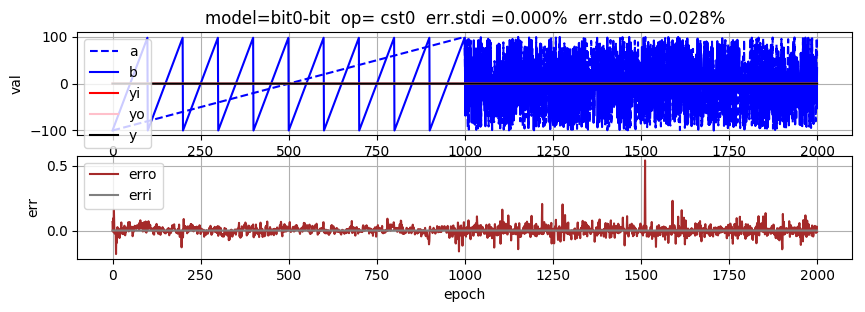

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

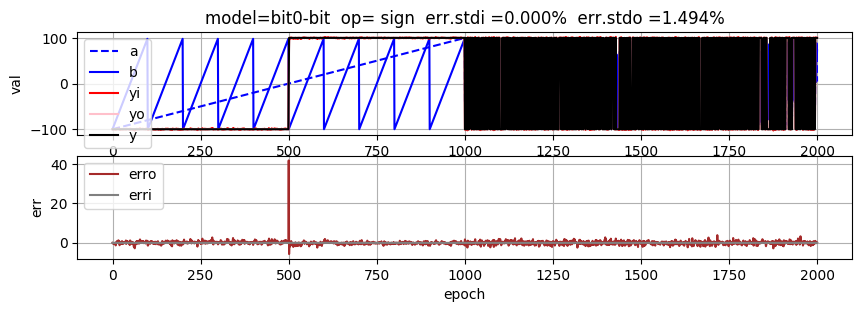

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

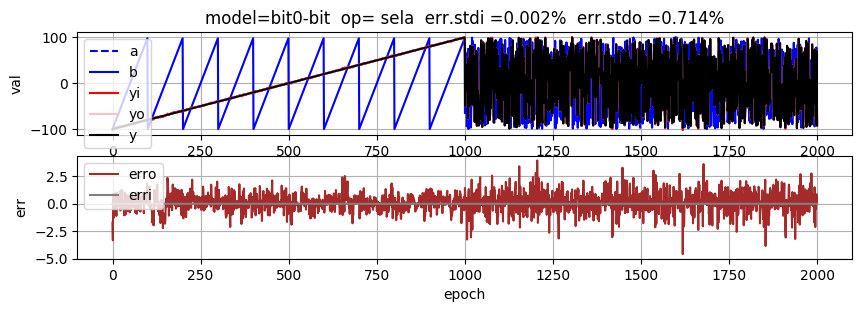

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

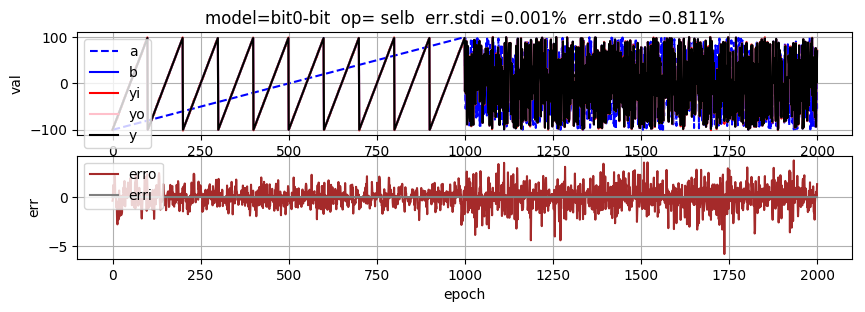

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

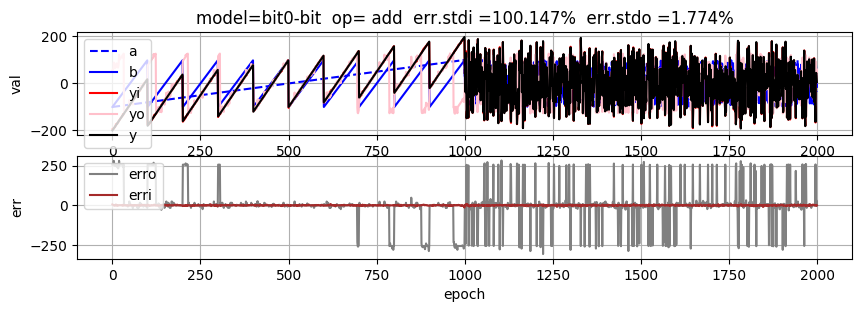

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

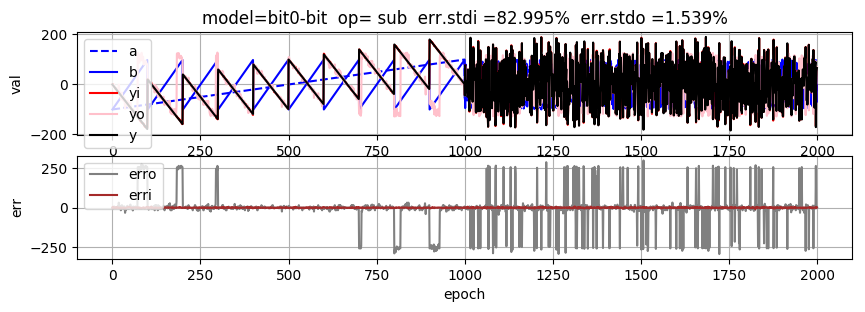

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

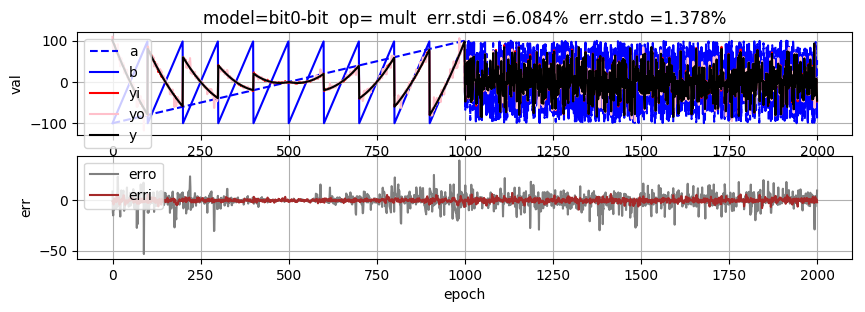

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

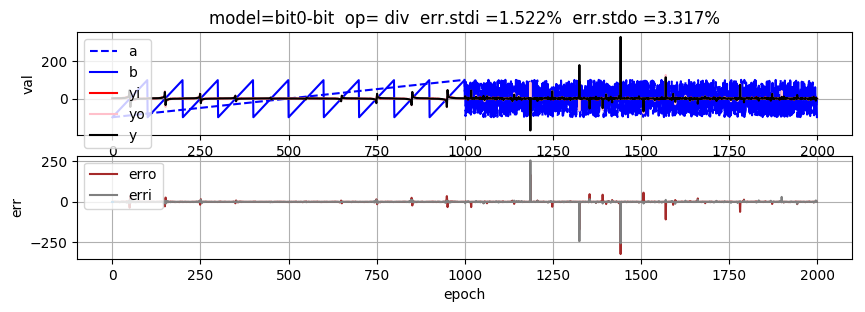

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

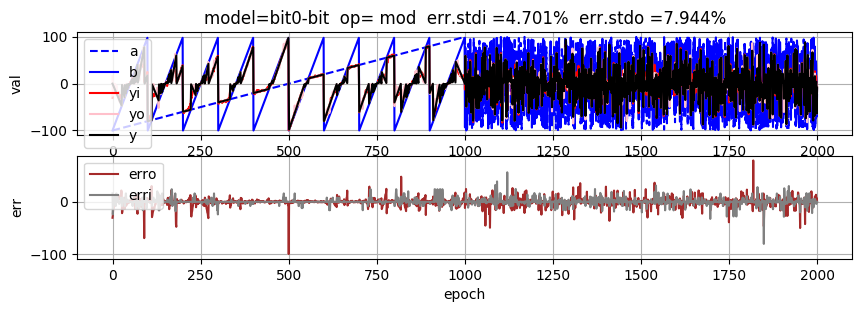

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

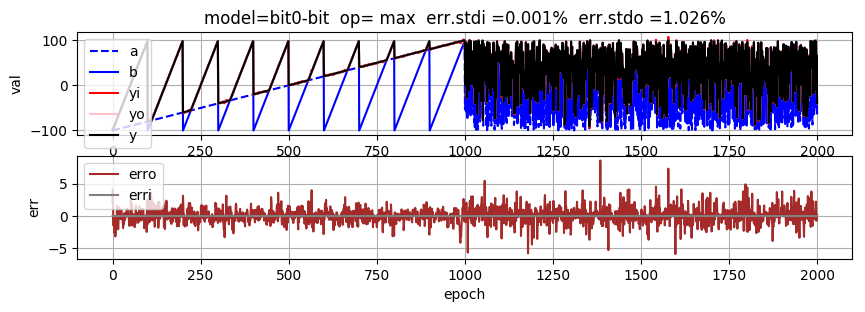

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

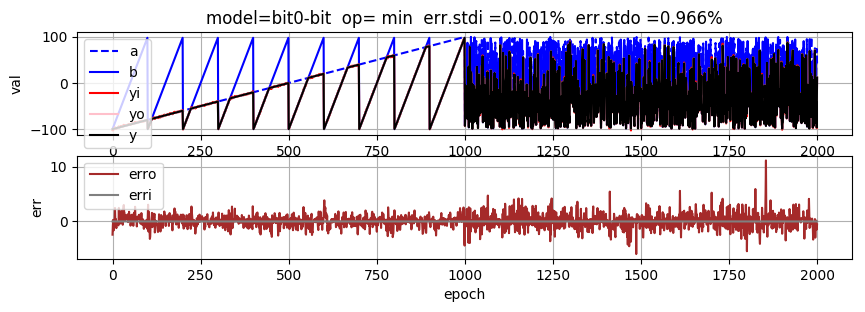

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

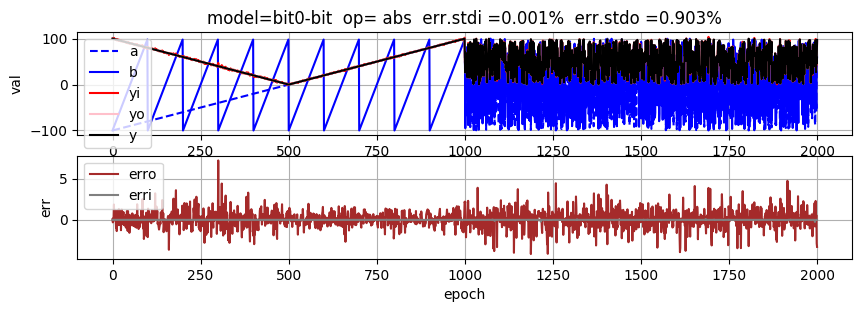

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

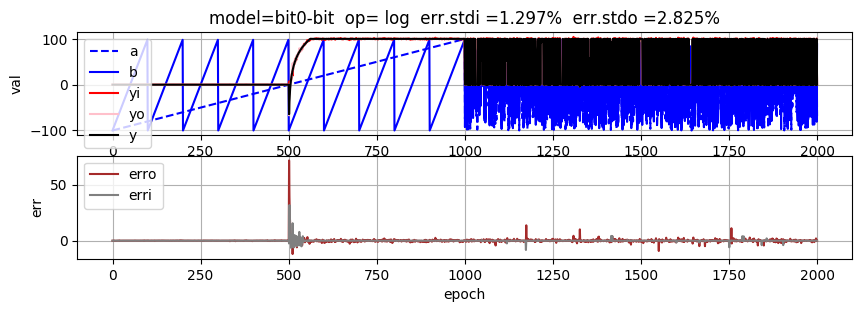

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

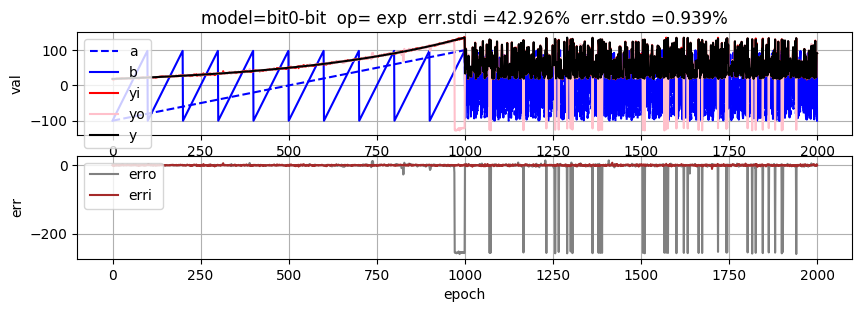

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

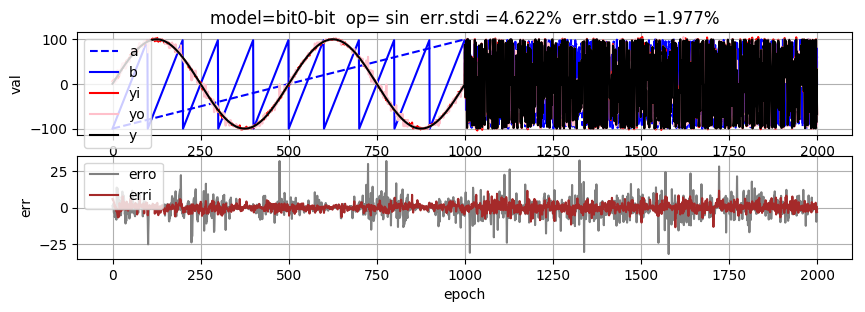

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

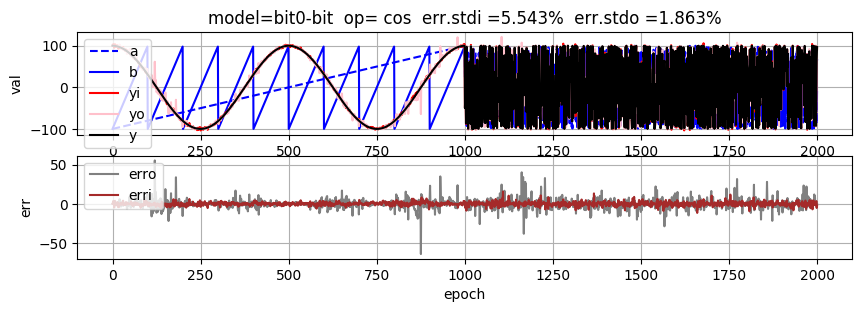

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

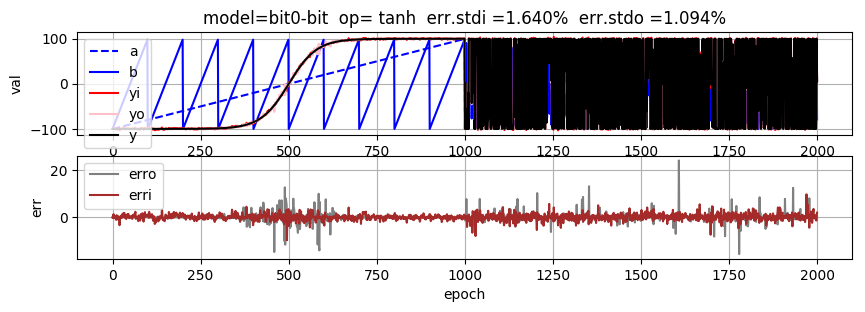

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

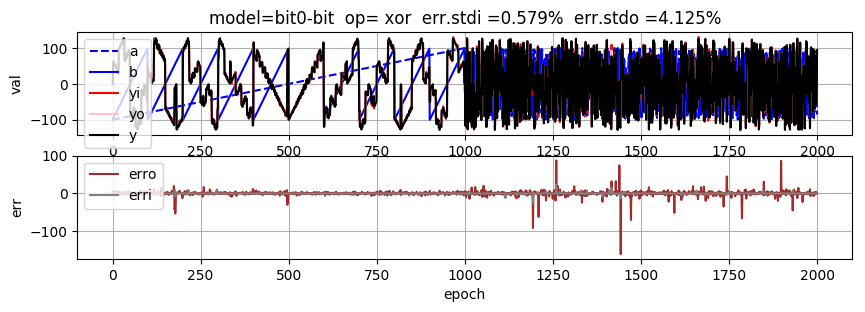

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

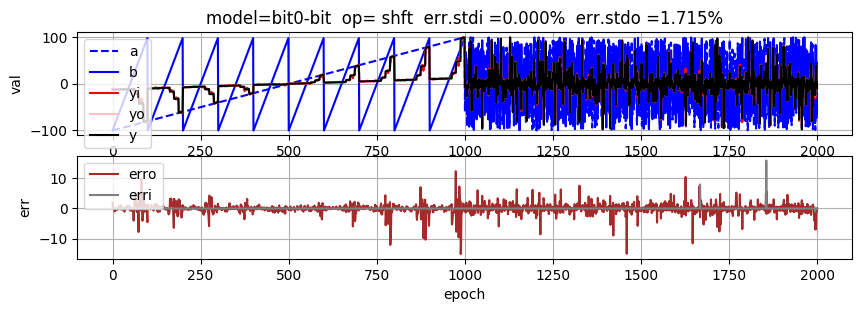

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

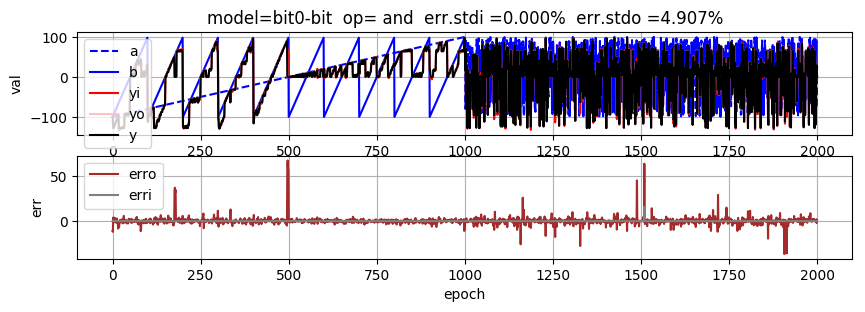

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

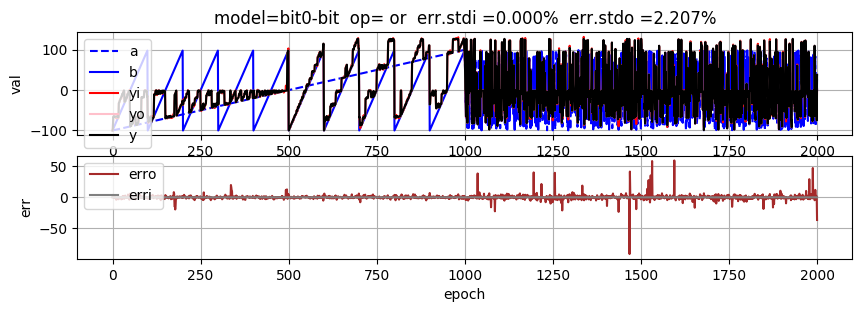

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

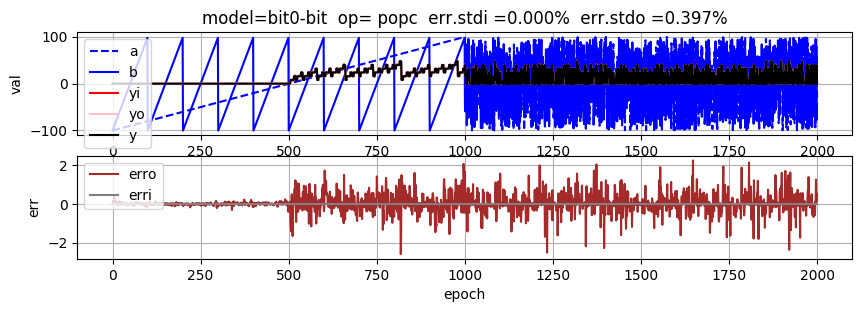

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

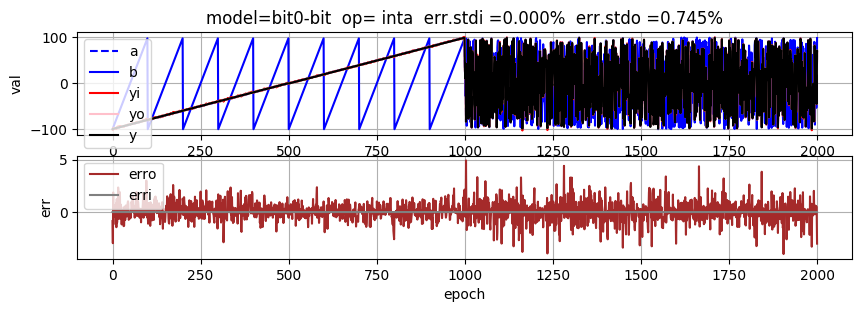

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

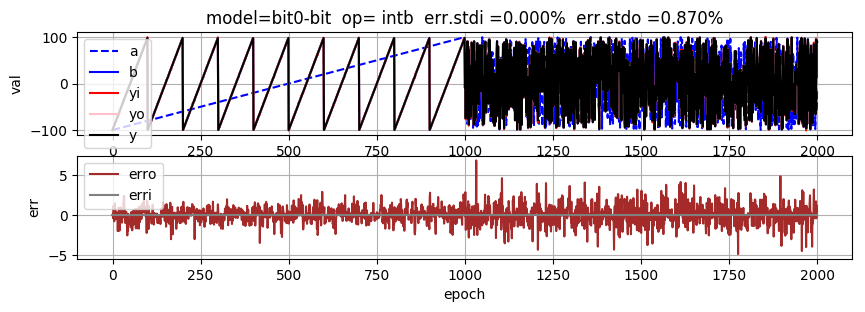

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

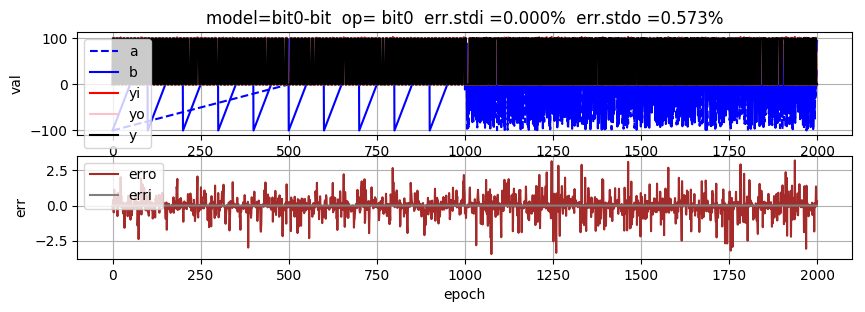

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

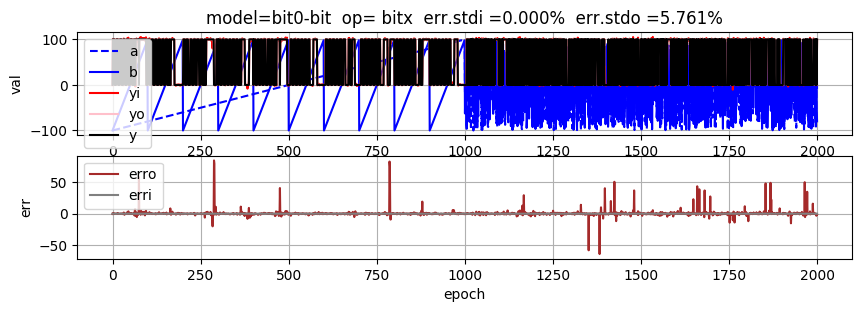

<IPython.core.display.Javascript object>

In [132]:
model='bit0'

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import


from matplotlib import pylab
from google.colab import widgets
tb = widgets.TabBar([str(opcodes[p]) for p in range(nops)])

#for i in range(26):
#  # Only select the first 3 tabs, and render others in the background.
#  with tb.output_to(i, select=(i < 3)):
#    pylab.plot([1, i, 3])
#    pylab.show()


#yo = alumodel.predict( [xx0,xx0], verbose=1)
#yo = alu0_model.predict( [xx0,xx0], verbose=1)

if(model=='alu0') : yo = alu0_model.predict( xx0, verbose=1)
if(model=='alu1') : yo = alu1_model.predict( xx0, verbose=1)
if(model=='alu2') : yo = alu2_model.predict( xx0, verbose=1)
if(model=='alu3') : yo = alu3_model.predict( xx0, verbose=1)
if(model=='alu4') : yo = alu4_model.predict( xx0, verbose=1)
if(model=='bit0') : ybo = bit0_model.predict( xx0, verbose=1)
if(model=='bit1') : ybo = bit1_model.predict( xx0, verbose=1)
if(model=='bit2') : ybo = bit2_model.predict( xx0, verbose=1)
if(model=='bit3') : ybo = bit3_model.predict( xx0, verbose=1)

  
if(model=='bit0' or model=='bit1' or model=='bit2' or model=='bit3' ) :

  yoff=1
  ybo[:,yoff:yoff+16] = np.round(ybo[:,yoff:yoff+16])

  #reconstruct y from bits
  print(model, ybo.shape, yoff)
  if(model=='bit0' or model=='bit1' or model=='bit2' or model=='bit3' ) :
    yi[:,0]=ybo[:, 0+yoff]*1/256 \
           +ybo[:, 1+yoff]*1/128 \
           +ybo[:, 2+yoff]*1/64  \
           +ybo[:, 3+yoff]*1/32  \
           +ybo[:, 4+yoff]*1/16  \
           +ybo[:, 5+yoff]*1/8   \
           +ybo[:, 6+yoff]*1/4   \
           +ybo[:, 7+yoff]*1/2   \
           +ybo[:, 8+yoff]*1     \
           +ybo[:, 9+yoff]*2     \
           +ybo[:,10+yoff]*4     \
           +ybo[:,11+yoff]*8     \
           +ybo[:,12+yoff]*16    \
           +ybo[:,13+yoff]*32    \
           +ybo[:,14+yoff]*64    \
           +ybo[:,15+yoff]*-128   

yo[:,0]=ybo[:,0]
erro=yo-y
erri=yi-y

for p in range(0,nops) :
 
  i=p*opsize
  #print(i)
  stdo=np.std(erro[i:i+1000])
  stdi=np.std(erri[i:i+1000])
  #print(std)
  
  dpi = 200
  xinch = 2000 / dpi
  yinch =  600 / dpi
  
  
  with tb.output_to(p,select=p<3) :

    # plot and save in the same size as the original
    fig = plt.figure(figsize=(xinch,yinch),dpi=100)
    
    plt.subplot(2, 1, 1)
  
    plt.plot(x [i+0:i+2000,0,0],label="a",color='blue',linestyle='--')
    plt.plot(x [i+0:i+2000,0,1],label="b",color='blue',linestyle='-')

    #plt.plot(yi[i+0:i+2000],    label="yi",color='pink')

    plt.plot(yo[i+0:i+2000],    label="yo",color='red')
    plt.plot(yi[i+0:i+2000],    label="yi",color='pink')
    plt.plot(y [i+0:i+2000],    label="y",color='black')
   
  
    title= 'model=' + ymodel[eons] + '-' + inp + "  op=" +' '+ op[i]+'  err.stdi ='+str('%3.3f%%'% stdi)+'  err.stdo ='+str('%3.3f%%'% stdo)
    
    plt.title(title)
    plt.ylabel('val')
    
    plt.legend(['a', 'b', 'yi', 'yo', 'y' ], loc='upper left')
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.ylabel('err')
    plt.xlabel('epoch')
    plt.grid(True)
    
    if stdi > stdo :
      plt.plot(erri[i:i+opsize], label="erri",color='gray')
      plt.plot(erro[i:i+opsize], label="erro",color='brown')
    else :
      plt.plot(erro[i:i+opsize], label="erro",color='brown')
      plt.plot(erri[i:i+opsize], label="erri",color='gray')

      
      plt.plot([0,0], label="zero")
    plt.legend(['erro','erri'], loc='upper left')

   #pylab.show()

  #
    if 0 :
      fig = plt.figure()
      ax = fig.gca(projection='3d')
      
      # Make data.
      XX = np.arange(-100, 100, 20)
      YY = np.arange(-100, 100, 20)
      XX, YY = np.meshgrid(XX, YY)
      ZZ = 0*(XX**2 + YY**2)
      #ZZ = np.sin(RR)
     
      z=np.zeros((10,10))
      #z=ZZ
      
      #print('YY=', YY.shape, YY[0:10,0])
      #print('ZZ=', ZZ.shape, ZZ[0:10,0])
      #print('z=', z.shape, z[0:10,0])
      
       
      for  ii in range(i,i+opsize) :
        vara=int(xx[ii,0]/20)
        varb=int(xx[ii,1]/20)
        varo=int(yo[ii])
        #printf('ii=%d vara=%d, varb=%d, varo=%d\n', ii, vara, varb, varo)
        
        #z[vara+10, varb+10]=varo
        ZZ[vara+5, varb+5]=varo
      #print(z[0:10,0:10])
      # Plot the surface.
      surf = ax.plot_surface(XX[1:11,1:11], YY[1:11,1:11], ZZ[1:11,1:11], cmap=cm.coolwarm,
                             linewidth=0, antialiased=False)
      plt.title(title)
      plt.ylabel('opa')
      plt.xlabel('opb')

    
      
      # Customize the z axis.
      #ax.set_zlim(-1.01, 1.01)
      #ax.zaxis.set_major_locator(LinearLocator(10))
      #ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
      
      # Add a color bar which maps values to colors.
      fig.colorbar(surf, shrink=0.5, aspect=5)
      
      plt.show()  
    
      fig = plt.figure()
      #ontour = plt.contour(XX, YY, z, colors='black')
      #ontour = plt.contour(XX, YY, z, colors='RdGy')
      contour = plt.contour(XX[1:10,1:10], YY[1:10,1:10], ZZ[1:10,1:10], 20, cmap='RdGy');
  
      plt.title(title)
      plt.ylabel('opa')
      plt.xlabel('opb')




In [0]:
print(xcat0[1,:])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


##Make a set of movies to show training history for each opcode

/content
/content
Successfully created the directory path 
/content/movies
rm: cannot remove './*.mp4': No such file or directory
(1000, 52000)
(52000, 1) ...


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationW

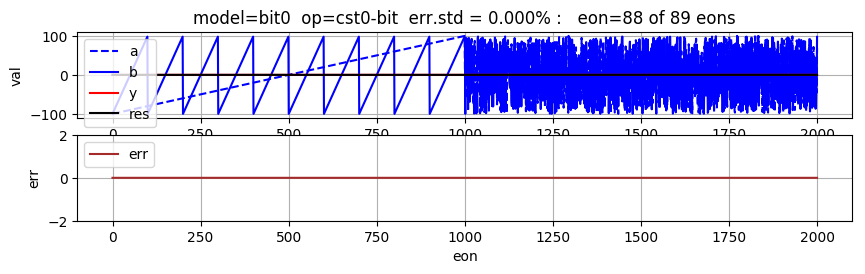

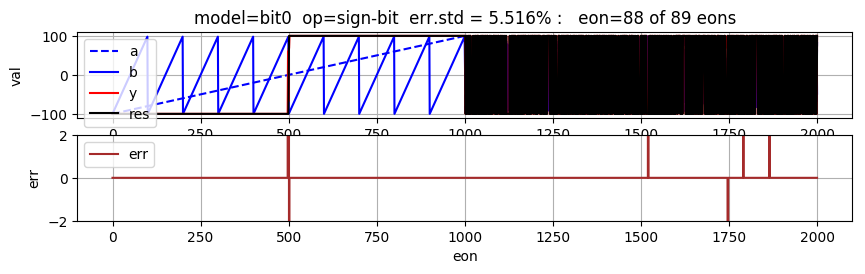

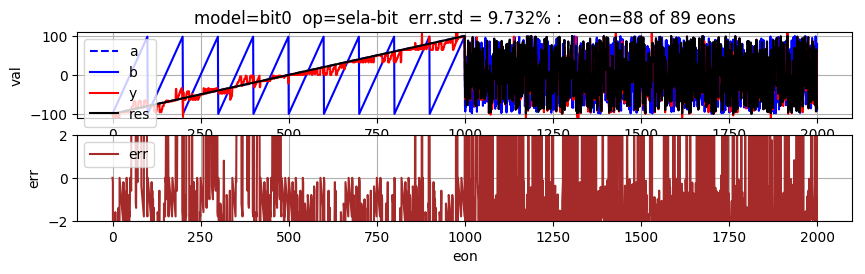

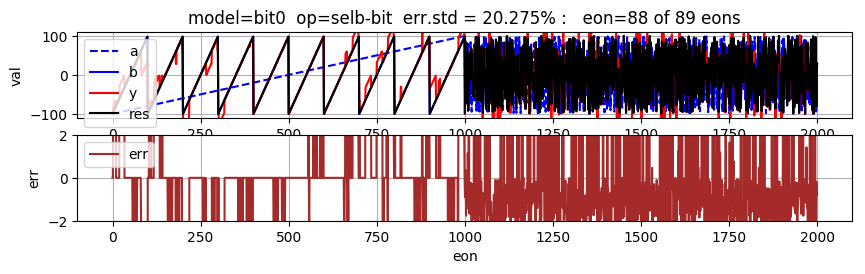

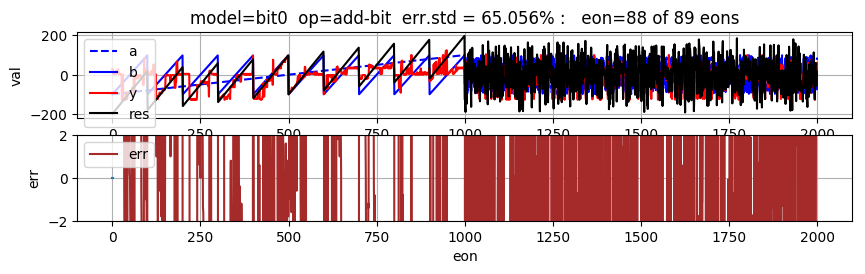

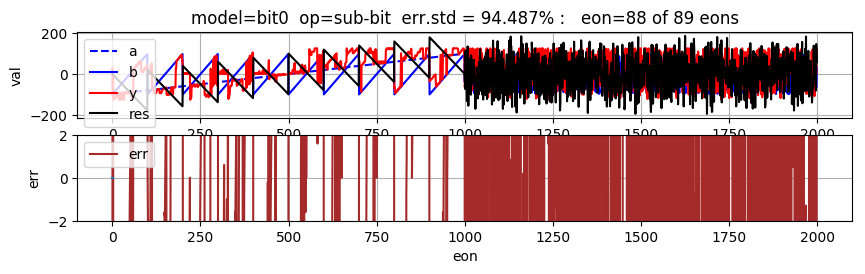

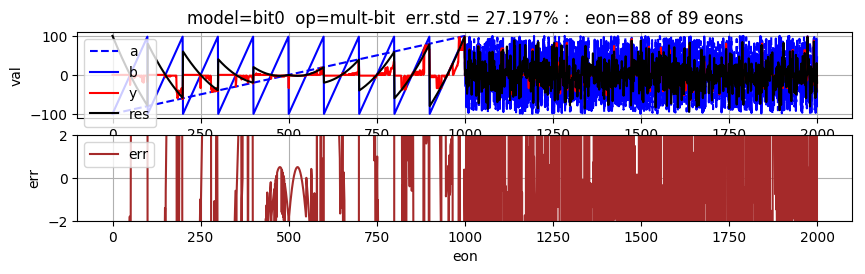

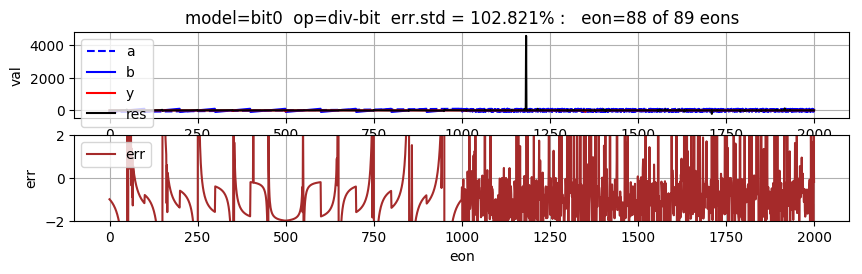

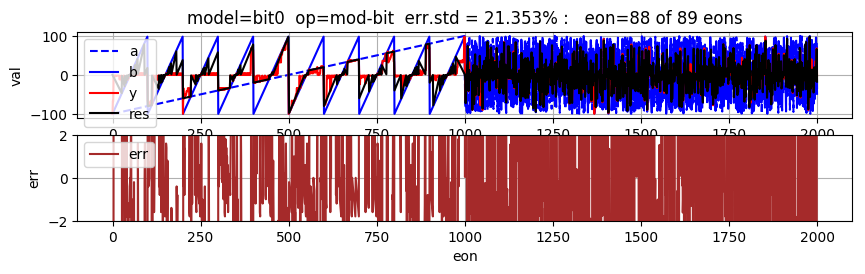

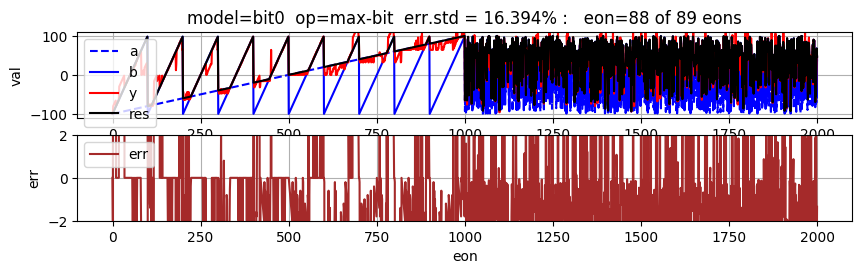

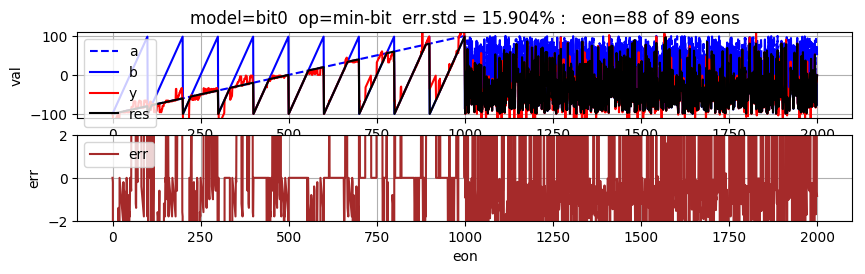

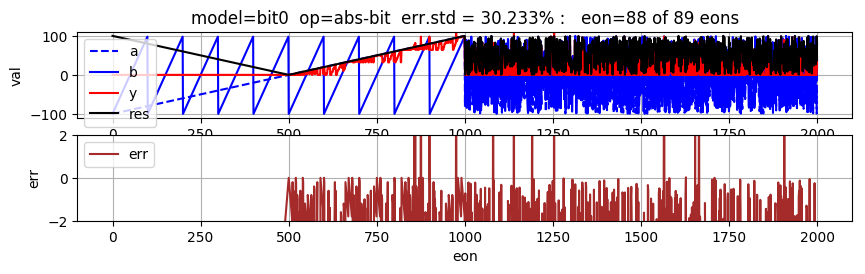

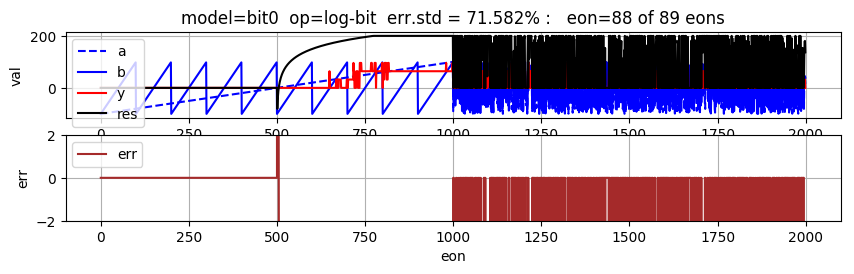

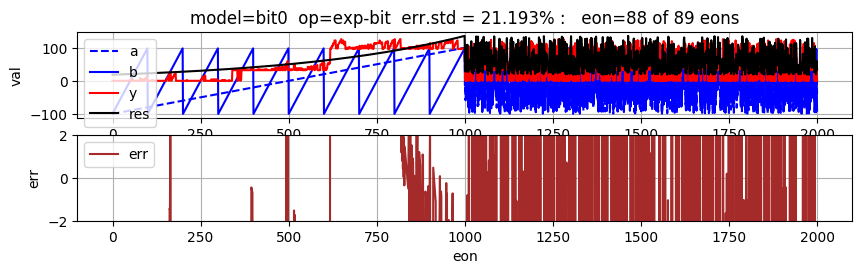

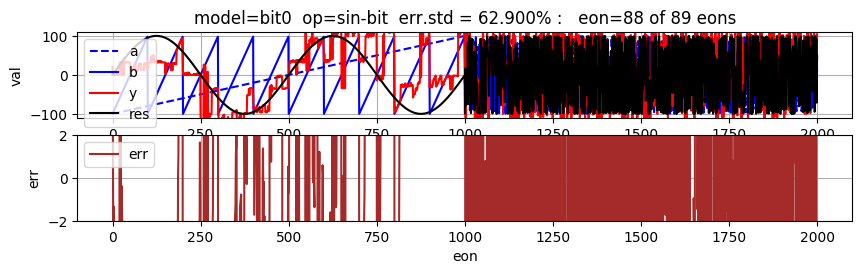

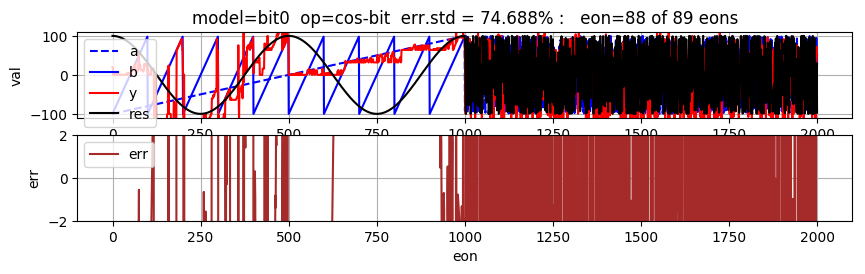

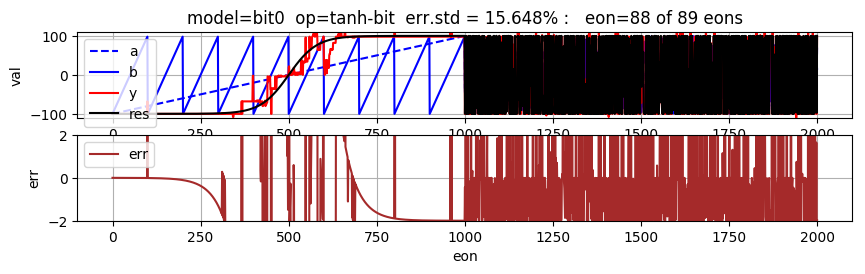

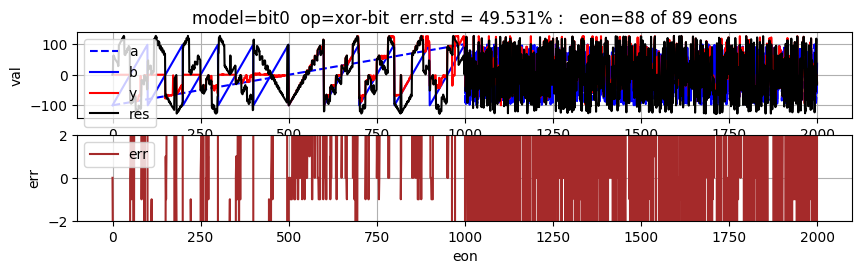

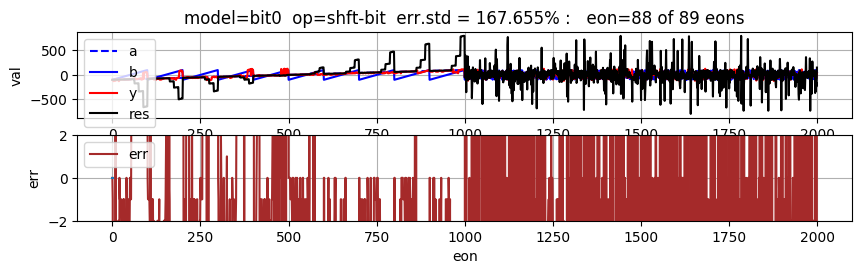

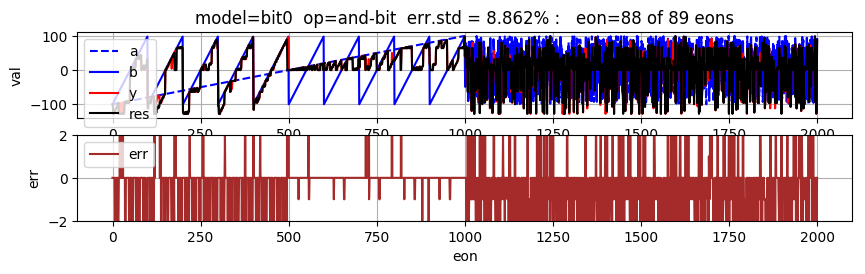

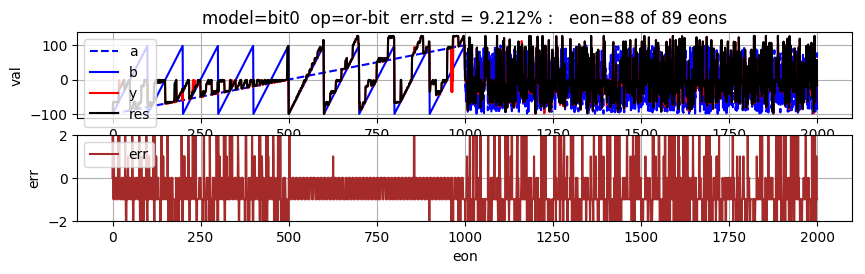

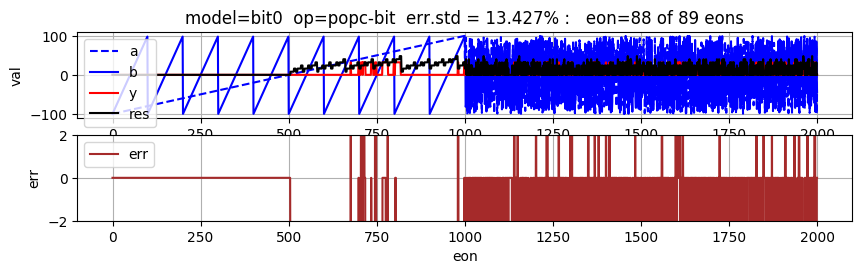

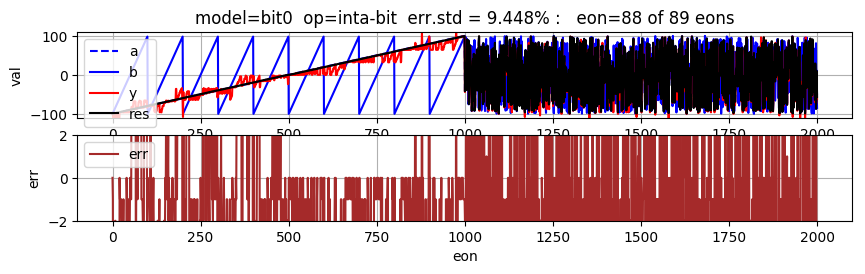

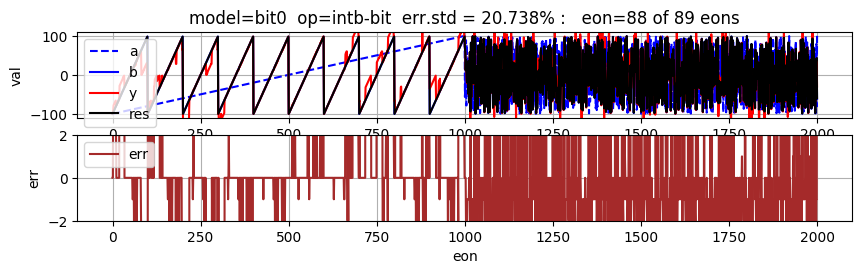

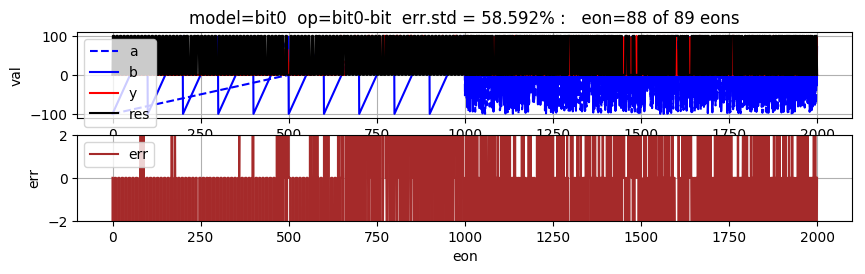

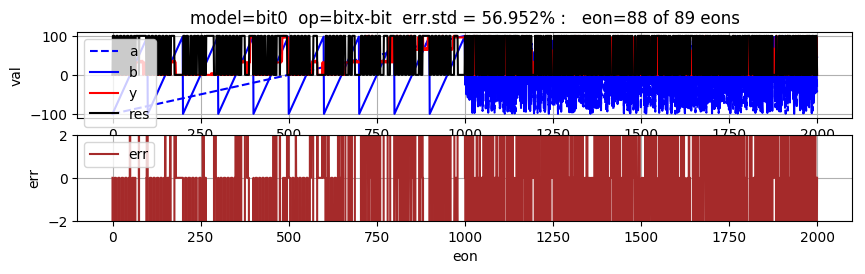

In [0]:
#make a movie 

import matplotlib
matplotlib.use("Agg")
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
from matplotlib.animation import FFMpegWriter
from matplotlib.animation import FFMpegFileWriter
from matplotlib.animation import ImageMagickWriter

import base64
from IPython.display import HTML


# Fixing random state for reproducibility
#np.random.seed(19680801)

#make the movie dir and delete any existing movies
import os

print(os.getcwd())
os.chdir('/content')
print(os.getcwd())
try:  
    os.mkdir("./movies")
except OSError:  
    print ("Creation of the directory %s"  % 'path')
else:  
    print ("Successfully created the directory %s " % 'path')
    
os.chdir('./movies')

print(os.getcwd())
!ls
!rm ./*.mp4

fps=eons/10
#fps=10

print(yhist.shape)

#FFMpegWriter = manimation.writers['ffmpeg']
#FFMpegWriter = manimation.writers['ImageMagickWriter']
#FFMpegWriter = manimation.writers['AVConvWriter']

metadata     = dict(title='Movie Test', artist='Matplotlib', comment='Movie support!')
writer       = FFMpegWriter(fps=fps, codec=None, bitrate=None, metadata=metadata)
#writer       = ImageMagickWriter(fps=1, codec=None, bitrate=None, metadata=metadata)

#ImageMagickWriter

dpi = 200.
xinch = 2000 / dpi
yinch =  500 / dpi

#fig = plt.figure(figsize=(xinch,yinch),dpi=100)



print(y.shape,ymodel[0])
#tb = widgets.TabBar([str(opcodes[p]) for p in range(26)])

for p in range (nops) :
  
#  with tb.output_to(p,select=p<3) :
  if(1) :

    vtitle='ALU_op_' +  opcodes[p] + '.mp4'
    fig = plt.figure(figsize=(xinch,yinch),dpi=100)
  
    with writer.saving(fig, vtitle, dpi=100):
      #wite 40 frames
      for f in range(eons):
        i=p*opsize
        
        #print('make frame p=%d frame=%d',p,f)
        yo=yhist[f, :]
        err=yo[:] - y[:,0]
        std=np.std(err[i:i+opsize])
        title= 'model=' + ymodel[f] + '  op=' + op[i]+'-'+inp+'  err.std = ' + str('%3.3f%% : '% std)+'  eon=' + str(f)+ ' of '  + str(eons) + ' eons'

        if f==0: 
          # plot 
          #fig = plt.figure(figsize=(xinch,yinch))
     
          plt.subplot(2, 1, 1)
    
          plt.plot(x  [ i:i+opsize,0,0],label="a",color='blue',linestyle='--')
          plt.plot(x  [ i:i+opsize,0,1],label="b",color='blue',linestyle='-')
          lo,=plt.plot(yo [ i:opsize],    label="res",color='red')
          plt.plot(y  [ i:i+opsize],    label="y",color='black')
          
             
          plt.title(title)
          plt.ylabel('val')
         
          plt.legend(['a', 'b', 'y', 'res', 'err'], loc='upper left')
          plt.grid(True)
      
          plt.subplot(2, 1, 2)
          plt.ylabel('err')
          plt.xlabel('eon')
          plt.grid(True)
          plt.ylim([-2,+2])
          
           
          le,=plt.plot(err[i:i+opsize], label="err",color='brown')
          plt.plot([0,0], label="zero")
          plt.legend(['err'], loc='upper left')
     
        else :
          
          lo.set_data(range(opsize),yo [ i:i+opsize])
          le.set_data(range(opsize),err[ i:i+opsize])
          
          plt.subplot(2, 1, 1)
          plt.title(title)
          
        plt.show()
        writer.grab_frame()

    video = open('/content/movies/'+vtitle, 'r+b').read()
    
    encoded = base64.b64encode(video)
    HTML(data='''<video alt="test" controls>
                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii')))
    
  video = open('/content/movies/ALU_op_cst0.mp4', 'r+b').read()
  encoded = base64.b64encode(video)
  HTML(data='''<video alt="test" controls>
                  <source src="data:video/mp4;base64,{0}" type="video/mp4" />
               </video>'''.format(encoded.decode('ascii')))